In [1]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

Meu nome é: Gabriel Moraes Barros 
Meu RA é: 192801


In [44]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

print('Keras ', keras.__version__)

Keras  2.0.5


In [3]:
import os
os.makedirs('../models', exist_ok=True)
nr.seed(20170603)

In [4]:
!ls ../utils

my_keras_utilities.py  __pycache__


In [5]:
sys.path.append('../utils')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter, train_network)


### Testa se um modulo foi importado

In [6]:
'my_keras_utilities' in sys.modules



True

try:
    train_network(model_week05, model_name, train_generator, validation_generator, **fit_params);
except AttributeError:
      print('nope')

In [12]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
!nvidia-smib

Backend:        tensorflow
Data format:    channels_first
/bin/sh: 1: nvidia-smib: not found


In [13]:
!ls ../Task\ 5

ls: cannot access '../Task 5': No such file or directory


## Função auxiliar

## Subindo o dataset

In [14]:
#auternar o comentário, se estiver no client ou no remote
data = np.load('/etc/jupyterhub/ia368z_2s2017/datasets/cifar10-redux.npz')
#data = np.load('../Task 5/cifar10-redux.npz')

In [15]:
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [16]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('int64'))

### Separando o conjunto de treinamento em validação e treinamento, numa proporção 80/20 %


In [17]:
p=np.random.permutation(len(X_train))
percent_factor=0.85
new_train_x = X_train[p]
new_train_y = y_train[p]


new_X_train = new_train_x[0:(np.floor(len(new_train_x)*percent_factor))]
new_y_train = new_train_y[0:(np.floor(len(new_train_y)*percent_factor))]
new_X_val = new_train_x[(np.ceil(len(new_train_x)*percent_factor)):]
new_y_val = new_train_y[(np.ceil(len(new_train_y)*percent_factor)):]


/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [18]:
print('X_train.shape',new_X_train.shape)
print('y_train.shape',new_y_train.shape)
print('X_val.shape',new_X_val.shape)
print('y_val.shape',new_y_val.shape)
print('y_test shape ',y_test.shape)
print('X_test.shape:',X_test.shape)


X_train.shape (1700, 3, 32, 32)
y_train.shape (1700,)
X_val.shape (300, 3, 32, 32)
y_val.shape (300,)
y_test shape  (500,)
X_test.shape: (500, 3, 32, 32)


In [19]:
print('Número de diferentes classes',len(np.unique(y_test)))


Número de diferentes classes 3


Normalizando os dados

In [20]:
a=0
print(np.mean(X_train))

113.781868652


In [21]:
#Guaranteeing that it only runs once
if (a==0):
    X_test = X_test.astype('float32')
    new_X_train = new_X_train.astype('float32')
    new_X_val = new_X_val.astype('float32')
    
    new_X_val /= 255.
    new_X_train /= 255.
    X_test /= 255.
    
    a=1
print(np.mean(new_X_train))
print(np.mean(new_X_val))
print(np.mean(X_test))

0.445836
0.448282
0.458465


nb_classes = 3 + 3
y_train_oh2 = np_utils.to_categorical(y_train, nb_classes)

y_test_oh2 = np_utils.to_categorical(y_test, nb_classes)
y_test_oh2 = np_utils.to_categorical(y_test, nb_classes)


In [22]:
from keras.utils import np_utils

## Transforma o vetor de labels para o formato de one-hot encoding.
n_classes = 3
y_train_oh = np_utils.to_categorical(new_y_train-3, n_classes)
y_val_oh = np_utils.to_categorical(new_y_val-3, n_classes)
y_test_oh = np_utils.to_categorical(y_test-3, n_classes)

y_test_oh = y_test_oh[:,3:]
y_train_oh = y_train_oh[:,3:]
y_val_oh = y_val_oh[:,3:]

In [23]:
print(y_train_oh.shape)
print(y_val_oh.shape)
print(y_test_oh.shape)


(1700, 3)
(300, 3)
(500, 3)


## Fazendo o data augmentation

In [24]:
print(X_train.shape)
print(X_test.shape)

(2000, 3, 32, 32)
(500, 3, 32, 32)


In [25]:
print('new x train shape', new_X_train.shape)
print('y train oh shape', y_train_oh.shape)

print('new x val shape', new_X_val.shape)
print('y val oh shape', y_val_oh.shape)



new x train shape (1700, 3, 32, 32)
y train oh shape (1700, 3)
new x val shape (300, 3, 32, 32)
y val oh shape (300, 3)


In [30]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
nb_train_samples = new_train_x.shape[0]
nb_val_samples = new_X_val.shape[0]
print('nb val samples',nb_val_samples)
nb_test_samples = X_test.shape[0]

# dimensions of our images.
img_width, img_height = 32, 32
batch_size=50
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
       #rescale=1./255,         # sempre faz o rescale
       shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
       zoom_range=0.2,         # sorteio entre 0 e 0.2
       horizontal_flip=True)   # sorteio 50%

test_datagen = ImageDataGenerator(rescale = 1/1.)
        #shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
       #zoom_range=0.2,         # sorteio entre 0 e 0.2
       #horizontal_flip=True)   # sorteio 50%

train_generator = train_datagen.flow(
        new_X_train,y_train_oh,                       # as amostras de treinamento
        batch_size=batch_size                # batch size do SGD
    )

validation_generator = train_datagen.flow(
        new_X_val, y_val_oh,                  # as amostras de validação
        batch_size=batch_size)

nb val samples 300


In [31]:
test_generator = test_datagen.flow(
        X_test, y_test_oh,                  # as amostras de validação
        batch_size=batch_size)

In [32]:
#Conjunto de treinaemnto
samples_train = train_datagen.flow(new_X_train)
n_samples_train = nb_train_samples/batch_size

#Conjunto de teste
samples_test = train_datagen.flow(X_test)
n_samples_test = nb_test_samples/batch_size
#Conjunto de validacao

samples_val = train_datagen.flow(new_X_val)
n_samples_val = nb_val_samples/batch_size

## Criando o mesmo modelo da semana passada, para comparar apenas o data_augmentation

In [33]:
n_classes = len(np.unique(y_test))
print(n_classes)

3


In [34]:
def model_build():
    img_rows, img_cols = 32, 32 # Dimensões das imagens
    #imagens com 3 canais e 32x32
    input_shape = (3, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    #primeira conv
    model.add(Conv2D(32, (3, 3),
                     input_shape=input_shape))
    model.add(Activation('relu'))
    
    #segunda conv
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    return model
model_week05 = model_build()

In [35]:
model_week05.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 30, 30)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 28, 28)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

## Treinamento

In [ ]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', nepochs=50, 
                  patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


In [90]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', nepochs=50, 
                  patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = [ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1),
        MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=7, verbose=0, mode='auto', epsilon=0.00001, cooldown=0, min_lr=0)
     ]
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb[1].get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb[1]])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


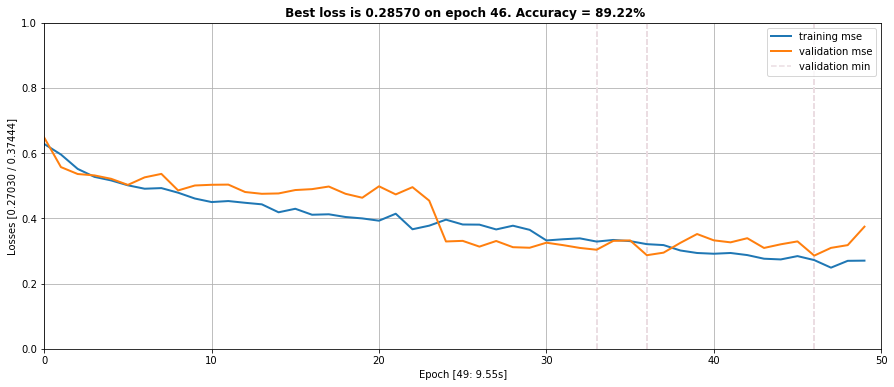

In [52]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)

fit_params = {
    'train_steps':     nb_train_samples / batch_size,
    'valid_steps':     nb_val_samples / batch_size,
    'opt':             'adam',    # SGD(lr=0.1, momentum=0.9, nesterov=True), 
    'nepochs':         50, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           False,
}

model_name = 'week05'


train_network(model_week05, model_name, train_generator, validation_generator, **fit_params);

## Avaliação

In [53]:
test_network(model_name, test_generator, X_test.shape[0] / batch_size)



Model from epoch 46
[INFO] evaluating in the test data set ...

[INFO] accuracy on the test data set: 79.27% [0.49067]


## Segunda parte, com redução de learning_rate com plateau


model_name = 'week05_2cb'


train_network(model_week05, model_name, train_generator, validation_generator, **fit_params);


Usei dois callbacks: o primeiro, ModelCheckpoint, salva o modelo que obteve melhor resultado no conjunto de validação. O segundo, ReduceLROnPlateau, reduz o fator de aprendizado quando não há melhora em no máximo 4 épocas. Não usei early stop pois o melhor modelo estava sendo salvo, e assim não há perigo de perder o melhor modelo no sobretreinamento.

model_name = './best'
model_file = model_name + '.model'

batch_size = 15
epochs = 500

cb = [
      ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=4, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
     ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
hist = model.fit(X_train, y_train_oh, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_oh), verbose=0, callbacks=cb)

# Segunda parte, com suba de pesos

## Subindo a VGG-16

In [54]:
from keras.applications.vgg16 import VGG16
modelvgg = VGG16(include_top=False, weights='imagenet')
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

/home/adessowiki/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py:181: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [55]:
modelvgg.layers.pop(18)
modelvgg.layers.pop(17)
modelvgg.layers.pop(16)
modelvgg.layers.pop(15)
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

In [64]:
gen_xtrain = 
train_features = modelvgg.predict(new_X_train)
print('train_features shape and type',train_features.shape,train_features.dtype)
validation_features = modelvgg.predict(new_X_val)
print('validation_features shape and type',validation_features.shape,train_features.dtype)
test_features = modelvgg.predict(X_test)
print('test_features shape and type',test_features.shape,train_features.dtype)

(1700, 512, 1, 1) float32
(300, 512, 1, 1) float32
(500, 512, 1, 1) float32


In [85]:
train_features.shape[1:]

(512, 1, 1)

In [66]:
model_name = '../cifar_redux_augmented_vgg'

modelVGG = Sequential()
modelVGG.add(Flatten(input_shape= train_features.shape[1:]))    
modelVGG.add(Dense(120))
modelVGG.add(Activation('relu'))
modelVGG.add(Dropout(0.5))
modelVGG.add(Dense(3))
modelVGG.add(Activation('softmax'))

In [67]:
modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               61560     
_________________________________________________________________
activation_7 (Activation)    (None, 120)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 363       
_________________________________________________________________
activation_8 (Activation)    (None, 3)                 0         
Total params: 61,923
Trainable params: 61,923
Non-trainable params: 0
_________________________________________________________________


In [99]:

def train_network_tl(model, model_name, Xtra, ytra, Xval=None, yval=None, 
                  opt='rmsprop', batch_size=60, nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        #cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
                # History, checkpoint, earlystop, plot losses:
        cb = [MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot), 
        ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=7, verbose=0, mode='auto', epsilon=0.00001, cooldown=0, min_lr=0)
     ]
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb[0].get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        h = model.fit(Xtra, ytra, batch_size=batch_size, epochs=tr_epochs, verbose=vv, 
                      validation_data=(Xval, yval), callbacks=[cb[0]])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb

SyntaxError: invalid syntax (<ipython-input-99-9f0ae521662e>, line 5)

In [108]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


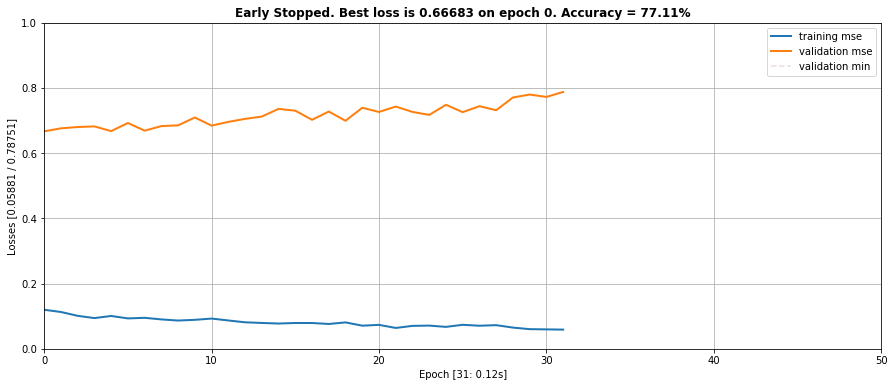

In [109]:
fit_params = {
    'opt':             'adam',
    'nepochs':         50, 
    'patience':        30,
    'ploss':           1.0,
    'reset':           True,
}
                             
model_name = 'transfer_learning'

train_network_tl(modelVGG, model_name, train_features,y_train_oh, validation_features,y_val_oh, **fit_params);
#train_network(modelVGG, model_name, train_features, y_train_oh, validation_features, y_val_oh,  **fit_params);

In [112]:
def test_network_tl(model_name, Xtest, ytest, batch_size=40):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

In [117]:
print(X_test.shape)
print(y_test.shape)
print(test_features.shape)

(500, 3, 32, 32)
(500,)
(500, 512, 1, 1)


In [118]:
test_network_tl(model_name, test_features,samples_test, X_test.shape[0])

Model from epoch 0
[INFO] evaluating in the test data set ...


TypeError: Error when checking model target: data should be a Numpy array, or list/dict of Numpy arrays. Found: <keras.preprocessing.image.NumpyArrayIterator object at 0x7f11ef09df60>...